# Imports

In [1]:
import os

from tbparse import SummaryReader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.distributions as dist
import matplotlib.pyplot as plt
from torch.utils._pytree import tree_map, tree_leaves
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D
from typing import Dict, List

import seaborn as sns

# Constants

In [2]:
SEQ_LEN = 4096  # context length
GENE_VOCAB_SIZE = 36601+19+2  # 36601 genes + 19 assays + 2 suspension types
METADATA_VOCAB_SIZE = 890+191+2+350+822  # 890 cell types + 191 development stages + 2 sexes + 350 diseases + 822 tissues
GENE_VALUE_VOCAB_SIZE = 2001
BATCH_SIZES = [128, 256, 512, 1024, 1536, 3072]

# Helper functions

In [11]:
def get_n_params(gene_vocab_size, metadata_vocab_size, gene_value_vocab_size, d_model, d_ffn, num_layers, seq_length=2048):
    embedding = (gene_vocab_size + metadata_vocab_size + 3 + 5) * d_model
    ln1 = d_model
    attn = 4 * d_model**2
    ln2 = d_model
    ffn = 2 * d_model * d_ffn
    transformer = num_layers * (ln1 + attn + ln2 + ffn)
    head = d_model * (metadata_vocab_size + gene_value_vocab_size)
    final_ln = d_model
    n_params = embedding + transformer + head + final_ln
    return n_params

def get_flops_per_seq(gene_vocab_size, metadata_vocab_size, gene_value_vocab_size, d_model, d_ffn, num_layers, key_size, seq_len):
    num_heads = d_model // key_size
    embeddings = 2 * (seq_len - 5) * gene_vocab_size * d_model + 2 * (metadata_vocab_size + 5) * d_model
    value_embeddings = 2 * (seq_len - 5) * (3 * d_model)
    kqv_proj = num_layers * 2 * 3 * seq_len * d_model * (key_size * num_heads)
    kq_logits = num_layers * 2 * (seq_len**2) * (key_size * num_heads)
    softmax = num_layers * 3 * (key_size * num_heads) * (seq_len**2)
    softmax_q_red = num_layers * (seq_len**2) * (key_size * num_heads)
    final_linear = num_layers * 2 * seq_len * (key_size * num_heads) * d_model
    sm_v_dot = num_layers * 2 * (seq_len**2) * (key_size * num_heads)
    attention_blocks = kqv_proj + kq_logits + softmax + softmax_q_red + sm_v_dot + final_linear
    dense_blocks = num_layers * 2 * seq_len * (d_model * d_ffn + d_ffn * d_model)
    final_logits = 2 * seq_len * d_model * (gene_value_vocab_size + metadata_vocab_size)
    # final_logits = 2 * (seq_len - 5) * d_model * gene_value_vocab_size + 2 * d_model * metadata_vocab_size
    # Layer norms: 7 FLOPs/activation, 2 LNs per decoder block
    layer_norm_flops = (1 + num_layers * 2) * 7 * (seq_len * d_model)
    # GeLU: estimate 20 FLOPs/activation, applied in FFN with 4x hidden dim
    gelu_flops = num_layers * 20 * (seq_len * d_ffn)
    total_flops_per_step = embeddings + value_embeddings + layer_norm_flops + attention_blocks + dense_blocks + final_logits + gelu_flops
    # Account for backward pass too
    total_flops_per_step *= 3
    # Embeddings don’t need to pass a delta back
    total_flops_per_step -= embeddings
    # total_flops_per_step -= position_embeddings

    return total_flops_per_step

# Function to compute isoflop parameters
def compute_isoflop(model_df: pd.DataFrame, n_flops: float, isoflop_id: int, batch_sizes: List[int]) -> pd.DataFrame:
    """Computes isoflop scaling values for different batch sizes."""
    isoflop_list = []

    for batch_size in batch_sizes:
        isoflop = model_df.copy()
        isoflop["isoflop"] = isoflop_id
        isoflop["batch_size"] = batch_size
        isoflop["n_seq"] = n_flops / isoflop["flops_per_seq"]
        isoflop["tpp"] = isoflop["n_seq"] * SEQ_LEN / isoflop["n_params"]
        isoflop["n_steps"] = isoflop["n_seq"] / isoflop["batch_size"]
        isoflop_list.append(isoflop)

    return pd.concat(isoflop_list, ignore_index=True)

# Function to process evaluation paths and update isoflop DataFrame
def process_eval_paths(isoflop_df: pd.DataFrame, eval_paths: Dict[int, Dict[str, str]]):
    """Processes evaluation paths and updates loss values in isoflop DataFrame."""
    for batch_size, models in eval_paths.items():
        for model_name, path in models.items():
            try:
                if path.endswith("tf_events"):
                    path = os.path.realpath(path)  # Resolve symlink if necessary
                
                df = SummaryReader(path).scalars
                df.drop(df[df["tag"].str.endswith("sec")].index, inplace=True)

                df["label"] = df["tag"].str.split("/").str[-1]
                for loss, label in zip(df["value"], df["label"]):
                    isoflop_df.loc[
                        (isoflop_df["name"] == model_name) & (isoflop_df["batch_size"] == batch_size), label
                    ] = loss

            except Exception as e:
                print(f"Error processing {path}: {e}")

# Define scaling law function
def scaling_law(xdata, E, c0, c1, c2, c3, alpha, beta, gamma, delta):
    """Functional form of neural scaling law."""
    N, D, B, M = xdata
    return E + c0 / (N ** alpha) + c1 / (D ** beta) + c2 / (B ** gamma) + c3 / (M ** delta)

def B_opt(D, c2, c3, gamma, delta):
    return ((gamma * c2) / (delta * c3)) ** (1 / (gamma + delta)) * (D / 4096) ** (delta / (gamma + delta))

# Download artifacts

In [81]:
# run this once to download artifacts
# !mkdir artifacts
# !gcloud storage cp -r gs://cellarium-scratch/cellariumgpt-artifacts/training/isoflops artifacts/

# Experiment

In [74]:
# Compute model configurations
model_data = {
    "name": ["10M", "19M", "30M", "59M", "98M", "146M", "203M", "527M", "1145M", "1998M"],
    "n_heads": [2, 3, 4, 6, 8, 10, 12, 20, 30, 40],
    "d_head": 64,
    "n_blocks": 32,
}

model_df = pd.DataFrame(model_data)
model_df["d_model"] = model_df["n_heads"] * model_df["d_head"]
model_df["d_ffn"] = (model_df["d_model"] * 2.5).astype(int)

model_df["n_params"] = get_n_params(
    GENE_VOCAB_SIZE, METADATA_VOCAB_SIZE, GENE_VALUE_VOCAB_SIZE,
    model_df["d_model"], model_df["d_ffn"], model_df["n_blocks"], SEQ_LEN
)

model_df["flops_per_seq"] = get_flops_per_seq(
    GENE_VALUE_VOCAB_SIZE, METADATA_VOCAB_SIZE, GENE_VALUE_VOCAB_SIZE,
    model_df["d_model"], model_df["d_ffn"], model_df["n_blocks"], model_df["d_head"], SEQ_LEN
)
model_df

,name,n_heads,d_head,n_blocks,d_model,d_ffn,n_params,flops_per_seq
0,10M,2,64,32,128,320,10248960,1786053873920
1,19M,3,64,32,192,480,18912384,2766053898624
2,30M,4,64,32,256,640,29935104,3804035981824
3,59M,6,64,32,384,960,59058432,6053946323712
4,98M,8,64,32,512,1280,97618944,8535784899584
5,146M,10,64,32,640,1600,145616640,11249551709440
6,203M,12,64,32,768,1920,203051520,14195246753280
7,527M,20,64,32,1280,3200,527162880,28297309268480
8,1145M,30,64,32,1920,4800,1144638720,51143272677120
9,1998M,40,64,32,2560,6400,1998044160,79787441935360


Compute number of FLOPs based 20 TPP for each model size

In [75]:
# 20 TPP
n_flops_20_tpp = 20 * model_df["n_params"] / SEQ_LEN * model_df["flops_per_seq"]
isoflop_flops = n_flops_20_tpp[[4, 6, 7, 8]]
isoflop_flops

4    4.068625e+18
6    1.407405e+19
7    7.283834e+19
8    2.858426e+20
dtype: float64

# Download artifacts

# Results

## Neural scaling law

In [76]:
# Compute isoflops for different configurations
isoflops = {}
for i, n_flops in enumerate(isoflop_flops, start=1):
    isoflops[i] = compute_isoflop(model_df, n_flops, i, BATCH_SIZES)

# Define evaluation paths
eval_paths = {
    1: {
        128: {
            '10M': './artifacts/isoflops/isoflop1/10M_bs128_064/events/events.out.tfevents.1737718438.cer-login-03.ai.alcf.anl.gov.898449.0',
            '19M': './artifacts/isoflops/isoflop1/19M_bs128_064/events/events.out.tfevents.1737731677.cer-login-02.ai.alcf.anl.gov.1051985.0',
            '30M': './artifacts/isoflops/isoflop1/30M_bs128_064/events/events.out.tfevents.1737720353.cer-login-03.ai.alcf.anl.gov.960508.0',
            '59M': './artifacts/isoflops/isoflop1/59M_bs128_064/events/events.out.tfevents.1737721604.cer-login-03.ai.alcf.anl.gov.1012580.0',
            '98M': './artifacts/isoflops/isoflop1/98M_bs128_064/events/events.out.tfevents.1737732218.cer-login-02.ai.alcf.anl.gov.1065304.0',
        },
        256: {
            '10M': './artifacts/isoflops/isoflop1/10M_bs256_064/events/events.out.tfevents.1737718443.cer-login-03.ai.alcf.anl.gov.898865.0',
            '19M': './artifacts/isoflops/isoflop1/19M_bs256_064/events/events.out.tfevents.1737719519.cer-login-03.ai.alcf.anl.gov.928478.0',
            '30M': './artifacts/isoflops/isoflop1/30M_bs256_064/events/events.out.tfevents.1737720780.cer-login-03.ai.alcf.anl.gov.979403.0',
            '59M': './artifacts/isoflops/isoflop1/59M_bs256_064/events/events.out.tfevents.1737722002.cer-login-03.ai.alcf.anl.gov.1029970.0',
            '98M': './artifacts/isoflops/isoflop1/98M_bs256_064/events/events.out.tfevents.1737723386.cer-login-03.ai.alcf.anl.gov.1083792.0',
        },
        512: {
            '10M': './artifacts/isoflops/isoflop1/10M_bs512_064/events/events.out.tfevents.1737781997.cer-login-03.ai.alcf.anl.gov.2553196.0',
            '19M': './artifacts/isoflops/isoflop1/19M_bs512_064/events/events.out.tfevents.1737784830.cer-login-03.ai.alcf.anl.gov.2621726.0',
            '30M': './artifacts/isoflops/isoflop1/30M_bs512_064/events/events.out.tfevents.1737785388.cer-login-03.ai.alcf.anl.gov.2636317.0',
            '59M': './artifacts/isoflops/isoflop1/59M_bs512_064/events/events.out.tfevents.1737785882.cer-login-03.ai.alcf.anl.gov.2649543.0',
            '98M': './artifacts/isoflops/isoflop1/98M_bs512_064/events/events.out.tfevents.1737834155.cer-login-02.ai.alcf.anl.gov.3334458.0',
        },
        1024: {
            '10M': './artifacts/isoflops/isoflop1/10M_bs1024_064/events/events.out.tfevents.1738898015.cer-login-01.ai.alcf.anl.gov.2629547.0',
            '19M': './artifacts/isoflops/isoflop1/19M_bs1024_064/events/events.out.tfevents.1738931821.cer-login-02.ai.alcf.anl.gov.3383688.0',
            '30M': './artifacts/isoflops/isoflop1/30M_bs1024_064/events/events.out.tfevents.1738934289.cer-login-02.ai.alcf.anl.gov.3435790.0',
            '59M': './artifacts/isoflops/isoflop1/59M_bs1024_064/events/events.out.tfevents.1738934837.cer-login-02.ai.alcf.anl.gov.3448738.0',
            '98M': './artifacts/isoflops/isoflop1/98M_bs1024_064/events/events.out.tfevents.1738935439.cer-login-02.ai.alcf.anl.gov.3463765.0',
        },
    },
    2: {
        256: {
            '10M': './artifacts/isoflops/isoflop2/10M_bs256_064/20241210_204430/events.out.tfevents.1733863473.cer-login-02.ai.alcf.anl.gov.3922711.0',
            '19M': './artifacts/isoflops/isoflop2/19M_bs256_064/20241211_113922/events.out.tfevents.1733917164.cer-login-02.ai.alcf.anl.gov.913622.0',
            '30M': './artifacts/isoflops/isoflop2/30M_bs256_064/20241211_204214/events.out.tfevents.1733949737.cer-login-02.ai.alcf.anl.gov.1654391.0',
            '59M': './artifacts/isoflops/isoflop2/59M_bs256_064/20241212_111343/events.out.tfevents.1734002025.cer-login-02.ai.alcf.anl.gov.2588682.0',
            '98M': './artifacts/isoflops/isoflop2/98M_bs256_064/events/events.out.tfevents.1737834836.cer-login-02.ai.alcf.anl.gov.3351498.0',
        },
        512: {
            '10M': './artifacts/isoflops/isoflop2/10M_bs512_064/events/events.out.tfevents.1737946793.cer-login-02.ai.alcf.anl.gov.1880267.0',
            '19M': './artifacts/isoflops/isoflop2/19M_bs512_064/events/events.out.tfevents.1737947383.cer-login-02.ai.alcf.anl.gov.1895458.0',
            '30M': './artifacts/isoflops/isoflop2/30M_bs512_064/events/events.out.tfevents.1737947872.cer-login-02.ai.alcf.anl.gov.1908382.0',
            '59M': './artifacts/isoflops/isoflop2/59M_bs512_064/events/events.out.tfevents.1737986965.cer-login-02.ai.alcf.anl.gov.2771850.0',
            '98M': './artifacts/isoflops/isoflop2/98M_bs512_064/events/events.out.tfevents.1737987612.cer-login-02.ai.alcf.anl.gov.2789722.0',
        },
        1024: {
            '10M': './artifacts/isoflops/isoflop2/10M_bs1024_064/events/events.out.tfevents.1738070777.cer-login-01.ai.alcf.anl.gov.1567580.0',
            '19M': './artifacts/isoflops/isoflop2/19M_bs1024_064/events/events.out.tfevents.1738072249.cer-login-01.ai.alcf.anl.gov.1588465.0',
            '30M': './artifacts/isoflops/isoflop2/30M_bs1024_064/events/events.out.tfevents.1738157714.cer-login-01.ai.alcf.anl.gov.2499629.0',
            '59M': './artifacts/isoflops/isoflop2/59M_bs1024_064/events/events.out.tfevents.1738161776.cer-login-01.ai.alcf.anl.gov.2543841.0',
            '98M': './artifacts/isoflops/isoflop2/98M_bs1024_064/events/events.out.tfevents.1738162384.cer-login-01.ai.alcf.anl.gov.2552406.0',
        },
        1536: {
            '10M': './artifacts/isoflops/isoflop2/10M_bs1536_064/events/events.out.tfevents.1737821519.cer-login-03.ai.alcf.anl.gov.3498215.0',
            '19M': './artifacts/isoflops/isoflop2/19M_bs1536_064/events/events.out.tfevents.1737912332.cer-login-02.ai.alcf.anl.gov.1066734.0',
            '30M': './artifacts/isoflops/isoflop2/30M_bs1536_064/events/events.out.tfevents.1737922839.cer-login-02.ai.alcf.anl.gov.1321109.0',
            '59M': './artifacts/isoflops/isoflop2/59M_bs1536_064/events/events.out.tfevents.1737939679.cer-login-02.ai.alcf.anl.gov.1714211.0',
            '98M': './artifacts/isoflops/isoflop2/98M_bs1536_064/events/events.out.tfevents.1737941540.cer-login-02.ai.alcf.anl.gov.1758653.0',
        },
    },
    3: {
        256: {
            '146M': './artifacts/isoflops/isoflop3/146M_bs256_064/events/events.out.tfevents.1738513270.cer-login-03.ai.alcf.anl.gov.2777240.0',
        },
        512: {
            '146M': './artifacts/isoflops/isoflop3/146M_bs512_064/events/events.out.tfevents.1738334875.cer-login-01.ai.alcf.anl.gov.260018.0',
        },
        1536: {
            '10M': './artifacts/isoflops/isoflop3/10M_bs1536_064/20241206_145348/events.out.tfevents.1733496830.cer-login-02.ai.alcf.anl.gov.1577903.0',
            '19M': './artifacts/isoflops/isoflop3/19M_bs1536_064/20241208_132406/events.out.tfevents.1733664249.cer-login-01.ai.alcf.anl.gov.1674894.0',
            '30M': './artifacts/isoflops/isoflop3/30M_bs1536_064/20241204_203630/events.out.tfevents.1733344593.cer-login-01.ai.alcf.anl.gov.3176518.0',
            '59M': './artifacts/isoflops/isoflop3/59M_bs1536_064/20241210_122043/events.out.tfevents.1733833246.cer-login-03.ai.alcf.anl.gov.1427219.0',
            '98M': './artifacts/isoflops/isoflop3/98M_bs1536_064/20241211_154231/events.out.tfevents.1733931754.cer-login-02.ai.alcf.anl.gov.1225077.0',
            '146M': './artifacts/isoflops/isoflop3/146M_bs1536_064/events/events.out.tfevents.1738070533.cer-login-01.ai.alcf.anl.gov.1563950.0',
        },
        3072: {
            '146M': './artifacts/isoflops/isoflop3/146M_bs3072_064/events/events.out.tfevents.1738194307.cer-login-02.ai.alcf.anl.gov.3120033.0',
        },
    },
    4: {
        3072: {
            '10M': './artifacts/isoflops/isoflop4/10M_bs3072_064_pot0/20241126_000630/events.out.tfevents.1732579592.cer-login-03.ai.alcf.anl.gov.2388187.0',
            '19M': './artifacts/isoflops/isoflop4/19M_bs3072_064/20241123_165501/events.out.tfevents.1732380903.cer-login-03.ai.alcf.anl.gov.3393037.0',
            '30M': './artifacts/isoflops/isoflop4/30M_bs3072_064/20241201_212527/events.out.tfevents.1733088330.cer-login-01.ai.alcf.anl.gov.1030660.0',
            '59M': './artifacts/isoflops/isoflop4/59M_bs3072_064/20241203_110906/events.out.tfevents.1733224149.cer-login-01.ai.alcf.anl.gov.2166440.0',
            '98M': './artifacts/isoflops/isoflop4/98M_bs3072_064/20241209_121430/events.out.tfevents.1733746473.cer-login-01.ai.alcf.anl.gov.2361752.0',
            '146M': './artifacts/isoflops/isoflop4/146M_bs3072_064/events/events.out.tfevents.1738672934.cer-login-02.ai.alcf.anl.gov.654721.0',
        },
    },
}

# Process evaluation paths
for i in range(1, 5):
    process_eval_paths(isoflops[i], eval_paths[i])

# Combine all isoflops into a single DataFrame
combined_isoflops = pd.concat(isoflops.values(), ignore_index=True)
combined_isoflops.dropna(subset=["loss"], inplace=True)

# Compute additional metrics
combined_isoflops["flops"] = combined_isoflops["flops_per_seq"] * combined_isoflops["n_steps"] * combined_isoflops["batch_size"]
combined_isoflops["n_tokens"] = combined_isoflops["n_seq"] * 4096

# Save results
# combined_isoflops.to_csv("combined_isoflops.csv", index=False)

combined_isoflops.head()


,name,n_heads,d_head,n_blocks,d_model,d_ffn,n_params,flops_per_seq,isoflop,batch_size,...,n_steps,cell_type,development_stage,disease,gene_value,sex,tissue,loss,flops,n_tokens
0,10M,2,64,32,128,320,10248960,1786053873920,1,128,...,17796.847996,1.205385,1.346716,0.297955,0.186924,0.254273,0.741679,0.336094,4.068625e+18,9.330674e+09
1,19M,3,64,32,192,480,18912384,2766053898624,1,128,...,11491.507567,1.243821,1.375652,0.310096,0.187932,0.258920,0.766202,0.342499,4.068625e+18,6.024860e+09
2,30M,4,64,32,256,640,29935104,3804035981824,1,128,...,8355.896069,1.274752,1.400059,0.321065,0.188830,0.261616,0.785271,0.347739,4.068625e+18,4.380896e+09
3,59M,6,64,32,384,960,59058432,6053946323712,1,128,...,5250.480861,1.324984,1.447838,0.336452,0.189822,0.264289,0.831560,0.356359,4.068625e+18,2.752764e+09
4,98M,8,64,32,512,1280,97618944,8535784899584,1,128,...,3723.867188,1.380001,1.492274,0.356803,0.190652,0.268626,0.876276,0.365371,4.068625e+18,1.952379e+09


In [77]:

# Extract relevant columns for curve fitting
N = combined_isoflops["n_params"].values
D = combined_isoflops["n_tokens"].values
B = combined_isoflops["batch_size"].values
M = combined_isoflops["n_steps"].values
L = combined_isoflops["loss"].values

# Initial parameter guesses
initial_guess = [0.25, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5]

# Fit the model
params, _ = curve_fit(scaling_law, (N, D, B, M), L, p0=initial_guess, maxfev=10000)

# Extract estimated parameters
E, c0, c1, c2, c3, alpha, beta, gamma, delta = params

# Define parameter names and descriptions separately
param_data = [
    ("E", "Irreducible loss", E),
    ("c0", "Scaling coefficient 1", c0),
    ("c1", "Scaling coefficient 2", c1),
    ("c2", "Scaling coefficient 3", c2),
    ("c3", "Scaling coefficient 4", c3),
    ("alpha", "Model scaling", alpha),
    ("beta", "Data scaling", beta),
    ("gamma", "Batch size scaling", gamma),
    ("delta", "Iteration scaling", delta),
]

# Convert to DataFrame
params_df = pd.DataFrame(param_data, columns=["parameter", "description", "value"])
params_df.set_index("parameter", inplace=True)
params_df

/tmp/ipykernel_2699120/3962555338.py:81: RuntimeWarning: divide by zero encountered in divide
  return E + c0 / (N ** alpha) + c1 / (D ** beta) + c2 / (B ** gamma) + c3 / (M ** delta)
/tmp/ipykernel_2699120/3962555338.py:81: RuntimeWarning: overflow encountered in divide
  return E + c0 / (N ** alpha) + c1 / (D ** beta) + c2 / (B ** gamma) + c3 / (M ** delta)


,description,value
parameter,,
E,Irreducible loss,0.251972
c0,Scaling coefficient 1,8.505624
c1,Scaling coefficient 2,158.896284
c2,Scaling coefficient 3,0.332140
c3,Scaling coefficient 4,1.655834
alpha,Model scaling,0.391671
beta,Data scaling,0.366819
gamma,Batch size scaling,0.516160
delta,Iteration scaling,0.547011


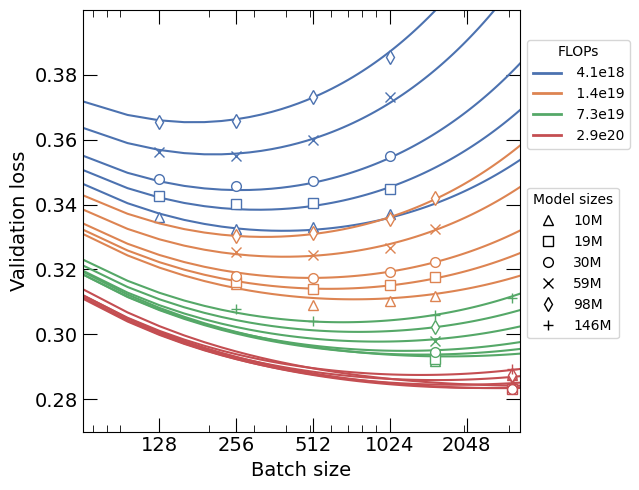

In [78]:
fig = plt.figure(figsize=(6.5, 5))
colors = sns.color_palette("deep")
marker = {"10M": "^", "19M": "s", "30M": "o", "59M": "x", "98M": "d", "146M": "+"}
for i in isoflops:
    for name in model_df["name"]:
        df = combined_isoflops[(combined_isoflops["isoflop"] == i) & (combined_isoflops["name"] == name)]
        if not df.empty:
            n = df["n_params"].iloc[0]
            d = df["n_tokens"].iloc[0]
            b = np.arange(64, 3073+256, 32)
            m = d / 4096 / b
            y = scaling_law((n, d, b, m), *params)
            plt.plot(b, y, linestyle="-", c=colors[i-1])
            plt.plot(df["batch_size"], df["loss"], linestyle="", marker=marker[name], c=colors[i-1], mfc="w", markersize=7)
ax = plt.gca()
plt.xlabel("Batch size", fontsize=14)
plt.ylabel("Validation loss", fontsize=14)
plt.ylim(0.27, 0.4)
plt.xlim(64, 3072+256)
plt.xscale("log")
ax.set_xticks([128, 256, 512, 1024, 2048])
# ax.minorticks_off()
plt.yticks([0.28, 0.3, 0.32, 0.34, 0.36, 0.38])
plt.tick_params(labelsize=14)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)
plt.tick_params(direction="in", which="major", length=10, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction="in", which="minor", length=5, bottom=True, top=True, left=True, right=True)

# Legend for IsoFLOP numbers (line colors)
isoflop_legend = [Line2D([0], [0], color=colors[i - 1], lw=2, label=f'{isoflop_flops.iloc[i-1]: .1e}'.replace("+", ""))
                  for i in isoflops]
# Legend for model names (marker styles)
model_legend = [Line2D([0], [0], color='black', marker=marker[name], linestyle='',
                       markersize=7, mfc="w", label=name) for name in marker]
# Add IsoFLOP legend outside the plot on the right
legend1 = ax.legend(handles=model_legend, title='Model sizes',
                    loc='center left', bbox_to_anchor=(1, 0.4))
# Add model legend below the IsoFLOP legend
ax.legend(handles=isoflop_legend, title='FLOPs',
          loc='center left', bbox_to_anchor=(1, 0.8))
ax.add_artist(legend1)

plt.tight_layout()

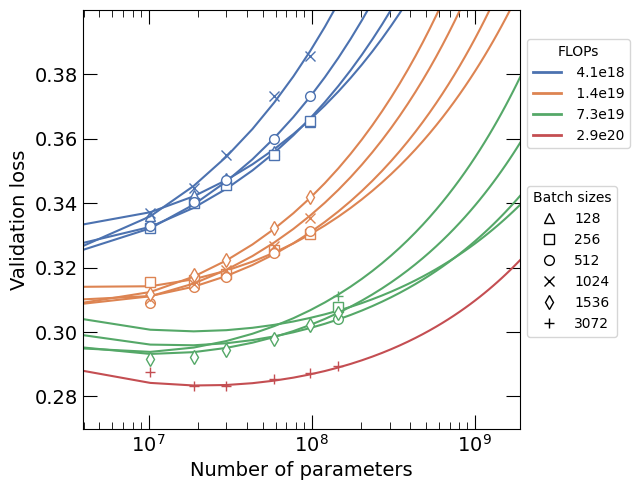

In [79]:
fig = plt.figure(figsize=(6.5, 5))
colors = sns.color_palette("deep")
marker = {128: "^", 256: "s", 512: "o", 1024: "x", 1536: "d", 3072: "+"}
for i in isoflops:
    for batch_size in [128, 256, 512, 1024, 1536, 3072]:
        df = combined_isoflops[(combined_isoflops["isoflop"] == i) & (combined_isoflops["batch_size"] == batch_size)]
        if not df.empty:
            flops = df["flops"].iloc[0]
            n_heads = np.arange(1, 40)
            n_blocks = 32
            flops_per_seq = get_flops_per_seq(
                GENE_VALUE_VOCAB_SIZE,
                METADATA_VOCAB_SIZE,
                GENE_VALUE_VOCAB_SIZE,
                n_heads * 64,
                n_heads * 64 * 2.5,
                n_blocks,
                64,
                SEQ_LEN,
            )
            n_seq = flops / flops_per_seq
            d = n_seq * 4096
            n = get_n_params(
                GENE_VOCAB_SIZE,
                METADATA_VOCAB_SIZE,
                GENE_VALUE_VOCAB_SIZE,
                n_heads * 64,
                n_heads * 64 * 2.5,
                n_blocks,
                SEQ_LEN,
            )
            m = n_seq / batch_size
            y = scaling_law((n, d, batch_size, m), *params)
            plt.plot(n, y, linestyle="-", c=colors[i-1])
            plt.plot(df["n_params"], df["loss"], linestyle="", marker=marker[batch_size], c=colors[i-1], mfc="w", markersize=7)
ax = plt.gca()
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Validation loss", fontsize=14)
plt.ylim(0.27, 0.4)
plt.xlim(n.min(), n.max())
plt.xscale("log")
plt.yticks([0.28, 0.3, 0.32, 0.34, 0.36, 0.38])
plt.tick_params(labelsize=14)
plt.tick_params(direction="in", which="major", length=10, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction="in", which="minor", length=5, bottom=True, top=True, left=True, right=True)

# Legend for IsoFLOP numbers (line colors)
isoflop_legend = [Line2D([0], [0], color=colors[i - 1], lw=2, label=f'{isoflop_flops.iloc[i-1]: .1e}'.replace("+", ""))
                  for i in isoflops]
# Legend for model names (marker styles)
model_legend = [Line2D([0], [0], color='black', marker=marker[name], linestyle='',
                       markersize=7, mfc="w", label=name) for name in marker]
# Add IsoFLOP legend outside the plot on the right
legend1 = ax.legend(handles=model_legend, title='Batch sizes',
                    loc='center left', bbox_to_anchor=(1, 0.4))
# Add model legend below the IsoFLOP legend
ax.legend(handles=isoflop_legend, title='FLOPs',
          loc='center left', bbox_to_anchor=(1, 0.8))
ax.add_artist(legend1)

plt.tight_layout()

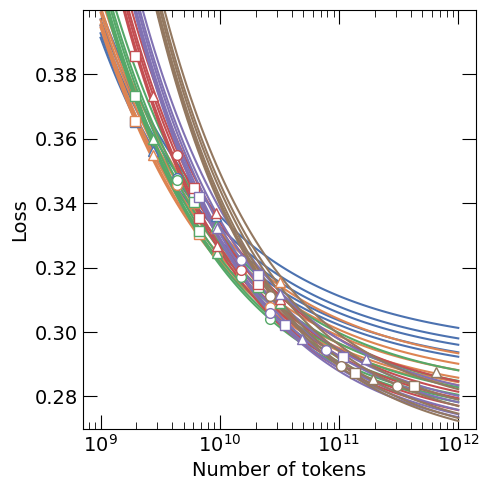

In [80]:
fig = plt.figure(figsize=(5, 5))
colors = sns.color_palette("deep")
marker = {"10M": "^", "19M": "s", "30M": "o", "59M": "^", "98M": "s", "146M": "o"}
for i, batch_size in enumerate([128, 256, 512, 1024, 1536, 3072]):
    for name in model_df["name"]:
        df = combined_isoflops[(combined_isoflops["batch_size"] == batch_size) & (combined_isoflops["name"] == name)]
        if not df.empty:
            n = df["n_params"].iloc[0]
            d = np.logspace(9, 12, 100)
            m = d / 4096 / batch_size
            y = scaling_law((n, d, batch_size, m), *params)
            plt.plot(d, y, linestyle="-", c=colors[i])
for i, batch_size in enumerate([128, 256, 512, 1024, 1536, 3072]):
    for name in model_df["name"]:
        df = combined_isoflops[(combined_isoflops["batch_size"] == batch_size) & (combined_isoflops["name"] == name)]
        if not df.empty:
            plt.plot(df["n_tokens"], df["loss"], linestyle="", marker=marker[name], c=colors[i], mfc="w", markersize=7)
ax = plt.gca()
plt.xlabel("Number of tokens", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.ylim(0.27, 0.4)
# plt.xlim(64, 3072+256)
plt.xscale("log")
# ax.set_xticks([128, 256, 512, 1024, 2048])
# ax.minorticks_off()
plt.yticks([0.28, 0.3, 0.32, 0.34, 0.36, 0.38])
plt.tick_params(labelsize=14)
# ax.xaxis.set_major_formatter(ScalarFormatter())
# ax.xaxis.get_major_formatter().set_scientific(False)
# ax.xaxis.get_major_formatter().set_useOffset(False)
plt.tick_params(direction="in", which="major", length=10, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction="in", which="minor", length=5, bottom=True, top=True, left=True, right=True)
plt.tight_layout()

## Compute optimal models

For given model sizes the number of flops doesn't follow a simple relationship of $C = 6ND$ as demonstrated below.

[]

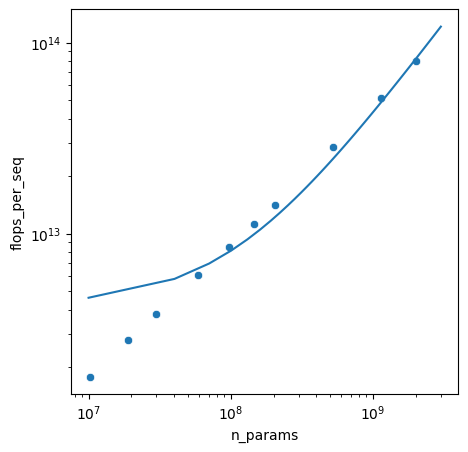

In [27]:
plt.figure(figsize=(5, 5))
sns.scatterplot(model_df, x="n_params", y="flops_per_seq")
res = linregress(model_df["n_params"], model_df["flops_per_seq"])
n_params = np.linspace(1e7, 3e9, 100)
n_flops = res.intercept + res.slope * n_params
plt.plot(n_params, n_flops)
plt.loglog()

It is better described by the linear relationship in the log-space.

[]

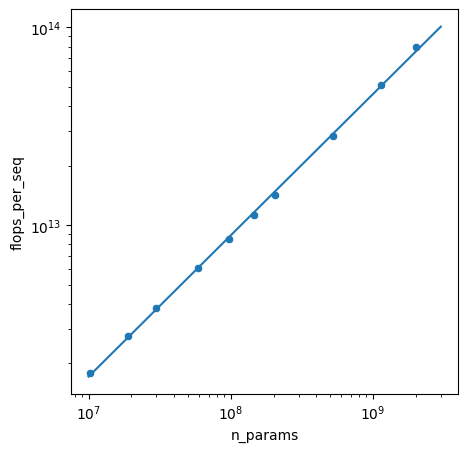

In [30]:
plt.figure(figsize=(5, 5))
sns.scatterplot(model_df, x="n_params", y="flops_per_seq")
res = linregress(np.log(model_df["n_params"]), np.log(model_df["flops_per_seq"]))
n_params = np.linspace(1e7, 3e9, 100)
n_flops = np.exp(res.intercept + res.slope * np.log(n_params))
plt.plot(n_params, n_flops)
plt.loglog()

But anyways, we also need to account for the batch size. The approach I'm taking here is doing a poor man's optimization by finding compute budgets C where the given model is the most optimal.

In [56]:
df = pd.DataFrame()
df["n_heads"] = [1, 2, 3, 4, 6, 8, 10, 12, 20, 30, 40]
df["d_head"] = 64
df["d_model"] = df["n_heads"] * df["d_head"]
df["d_ffn"] = (df["d_model"] * 2.5).astype(int)
df["n_blocks"] = 32
df["n_params"] = get_n_params(
    GENE_VOCAB_SIZE,
    METADATA_VOCAB_SIZE,
    GENE_VALUE_VOCAB_SIZE,
    df["d_model"],
    df["d_ffn"],
    df["n_blocks"],
    SEQ_LEN,
)
df["name"] = ["5M", "10M", "19M", "30M", "59M", "98M", "146M", "203M", "527M", "1145M", "1998M"]
df["flops_per_seq"] = get_flops_per_seq(
    GENE_VALUE_VOCAB_SIZE,
    METADATA_VOCAB_SIZE,
    GENE_VALUE_VOCAB_SIZE,
    df["d_model"],
    df["d_ffn"],
    df["n_blocks"],
    df["d_head"],
    SEQ_LEN,
)
model_df = df

In [57]:
# 10M
compute_optimal_df = model_df.copy()
compute_optimal_df["n_flops"] = 8e19
compute_optimal_df["n_seq"] = compute_optimal_df["n_flops"] / compute_optimal_df["flops_per_seq"]
compute_optimal_df["n_seq"] = compute_optimal_df["n_seq"].round()
compute_optimal_df["n_tokens"] = compute_optimal_df["n_seq"] * 4096
compute_optimal_df["batch_size"] = ((gamma * c2) / (delta * c3)) ** (1 / (gamma + delta)) * (compute_optimal_df["n_seq"]) ** (delta / (gamma + delta))
compute_optimal_df["batch_size"] = compute_optimal_df["batch_size"].round()
compute_optimal_df["n_steps"] = compute_optimal_df["n_seq"] / compute_optimal_df["batch_size"]
compute_optimal_df["n_steps"] = compute_optimal_df["n_steps"].round()
compute_optimal_df["predicted_loss"] = scaling_law((compute_optimal_df["n_params"], compute_optimal_df["n_tokens"], compute_optimal_df["batch_size"], compute_optimal_df["n_steps"]), *params)
# find minimum loss
compute_optimal_df.loc[compute_optimal_df["predicted_loss"].idxmin()]

n_heads                                2
d_head                                64
d_model                              128
d_ffn                                320
n_blocks                              32
n_params                        10248960
name                                 10M
flops_per_seq              1786053873920
n_flops           80000000000000000000.0
n_seq                         44791482.0
n_tokens                  183465910272.0
batch_size                        1806.0
n_steps                          24801.0
predicted_loss                  0.292433
Name: 1, dtype: object

(0.29, 0.3)

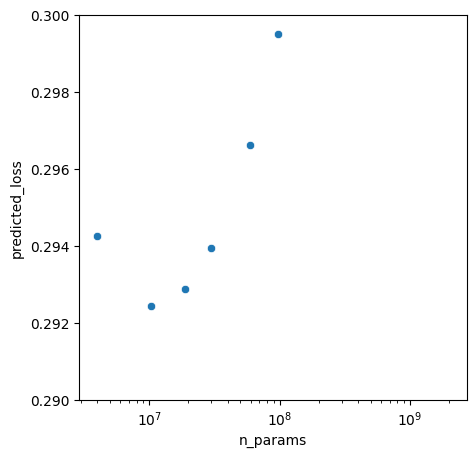

In [58]:
plt.figure(figsize=(5, 5))
sns.scatterplot(compute_optimal_df, x="n_params", y="predicted_loss")
plt.xscale("log")
plt.ylim(0.290,0.30)

In [59]:
# 19M
compute_optimal_df = model_df.copy()
compute_optimal_df["n_flops"] = 1.6e20
compute_optimal_df["n_seq"] = compute_optimal_df["n_flops"] / compute_optimal_df["flops_per_seq"]
compute_optimal_df["n_seq"] = compute_optimal_df["n_seq"].round()
compute_optimal_df["n_tokens"] = compute_optimal_df["n_seq"] * 4096
compute_optimal_df["batch_size"] = ((gamma * c2) / (delta * c3)) ** (1 / (gamma + delta)) * (compute_optimal_df["n_seq"]) ** (delta / (gamma + delta))
compute_optimal_df["batch_size"] = compute_optimal_df["batch_size"].round()
compute_optimal_df["n_steps"] = compute_optimal_df["n_seq"] / compute_optimal_df["batch_size"]
compute_optimal_df["n_steps"] = compute_optimal_df["n_steps"].round()
compute_optimal_df["predicted_loss"] = scaling_law((compute_optimal_df["n_params"], compute_optimal_df["n_tokens"], compute_optimal_df["batch_size"], compute_optimal_df["n_steps"]), *params)
# find minimum loss
compute_optimal_df.loc[compute_optimal_df["predicted_loss"].idxmin()]

n_heads                                 3
d_head                                 64
d_model                               192
d_ffn                                 480
n_blocks                               32
n_params                         18912384
name                                  19M
flops_per_seq               2766053898624
n_flops           160000000000000000000.0
n_seq                          57844137.0
n_tokens                   236929585152.0
batch_size                         2060.0
n_steps                           28080.0
predicted_loss                   0.287241
Name: 2, dtype: object

(0.285, 0.295)

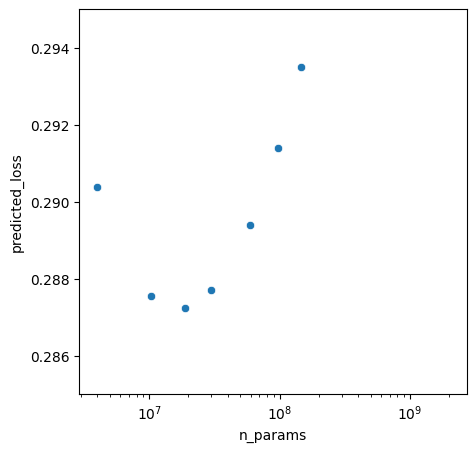

In [60]:
plt.figure(figsize=(5, 5))
sns.scatterplot(compute_optimal_df, x="n_params", y="predicted_loss")
plt.xscale("log")
plt.ylim(0.285,0.295)

In [61]:
# 30M
compute_optimal_df = model_df.copy()
compute_optimal_df["n_flops"] = 4.2e20
compute_optimal_df["n_seq"] = compute_optimal_df["n_flops"] / compute_optimal_df["flops_per_seq"]
compute_optimal_df["n_seq"] = compute_optimal_df["n_seq"].round()
compute_optimal_df["n_tokens"] = compute_optimal_df["n_seq"] * 4096
compute_optimal_df["batch_size"] = ((gamma * c2) / (delta * c3)) ** (1 / (gamma + delta)) * (compute_optimal_df["n_seq"]) ** (delta / (gamma + delta))
compute_optimal_df["batch_size"] = compute_optimal_df["batch_size"].round()
compute_optimal_df["n_steps"] = compute_optimal_df["n_seq"] / compute_optimal_df["batch_size"]
compute_optimal_df["n_steps"] = compute_optimal_df["n_steps"].round()
compute_optimal_df["predicted_loss"] = scaling_law((compute_optimal_df["n_params"], compute_optimal_df["n_tokens"], compute_optimal_df["batch_size"], compute_optimal_df["n_steps"]), *params)
# find minimum loss
compute_optimal_df.loc[compute_optimal_df["predicted_loss"].idxmin()]

n_heads                                 4
d_head                                 64
d_model                               256
d_ffn                                 640
n_blocks                               32
n_params                         29935104
name                                  30M
flops_per_seq               3804035981824
n_flops           420000000000000000000.0
n_seq                         110409050.0
n_tokens                   452235468800.0
batch_size                         2872.0
n_steps                           38443.0
predicted_loss                   0.281025
Name: 3, dtype: object

(0.28, 0.29)

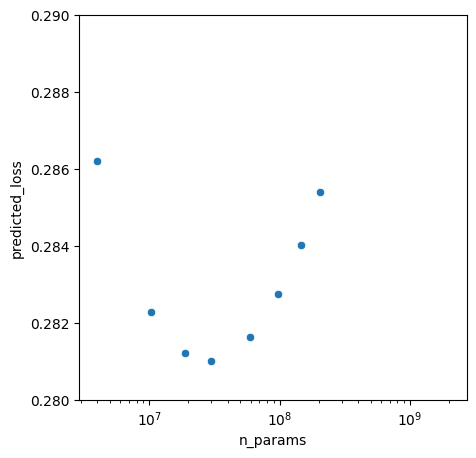

In [62]:
plt.figure(figsize=(5, 5))
sns.scatterplot(compute_optimal_df, x="n_params", y="predicted_loss")
plt.xscale("log")
plt.ylim(0.28,0.29)

In [63]:
# 59M
compute_optimal_df = model_df.copy()
compute_optimal_df["n_flops"] = 1e21
compute_optimal_df["n_seq"] = compute_optimal_df["n_flops"] / compute_optimal_df["flops_per_seq"]
compute_optimal_df["n_seq"] = compute_optimal_df["n_seq"].round()
compute_optimal_df["n_tokens"] = compute_optimal_df["n_seq"] * 4096
compute_optimal_df["batch_size"] = ((gamma * c2) / (delta * c3)) ** (1 / (gamma + delta)) * (compute_optimal_df["n_seq"]) ** (delta / (gamma + delta))
compute_optimal_df["batch_size"] = compute_optimal_df["batch_size"].round()
compute_optimal_df["n_steps"] = compute_optimal_df["n_seq"] / compute_optimal_df["batch_size"]
compute_optimal_df["n_steps"] = compute_optimal_df["n_steps"].round()
compute_optimal_df["predicted_loss"] = scaling_law((compute_optimal_df["n_params"], compute_optimal_df["n_tokens"], compute_optimal_df["batch_size"], compute_optimal_df["n_steps"]), *params)
# find minimum loss
compute_optimal_df.loc[compute_optimal_df["predicted_loss"].idxmin()]

n_heads                                  6
d_head                                  64
d_model                                384
d_ffn                                  960
n_blocks                                32
n_params                          59058432
name                                   59M
flops_per_seq                6053946323712
n_flops           1000000000000000000000.0
n_seq                          165181511.0
n_tokens                    676583469056.0
batch_size                          3534.0
n_steps                            46741.0
predicted_loss                    0.276448
Name: 4, dtype: object

(0.275, 0.285)

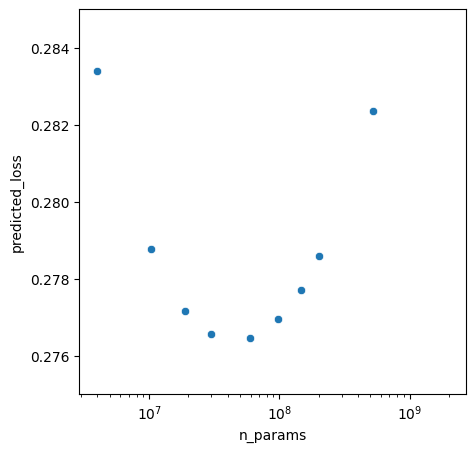

In [64]:
plt.figure(figsize=(5, 5))
sns.scatterplot(compute_optimal_df, x="n_params", y="predicted_loss")
plt.xscale("log")
plt.ylim(0.275,0.285)

In [65]:
# 98M
compute_optimal_df = model_df.copy()
compute_optimal_df["n_flops"] = 2.5e21
compute_optimal_df["n_seq"] = compute_optimal_df["n_flops"] / compute_optimal_df["flops_per_seq"]
compute_optimal_df["n_seq"] = compute_optimal_df["n_seq"].round()
compute_optimal_df["n_tokens"] = compute_optimal_df["n_seq"] * 4096
compute_optimal_df["batch_size"] = ((gamma * c2) / (delta * c3)) ** (1 / (gamma + delta)) * (compute_optimal_df["n_seq"]) ** (delta / (gamma + delta))
compute_optimal_df["batch_size"] = compute_optimal_df["batch_size"].round()
compute_optimal_df["n_steps"] = compute_optimal_df["n_seq"] / compute_optimal_df["batch_size"]
compute_optimal_df["n_steps"] = compute_optimal_df["n_steps"].round()
compute_optimal_df["predicted_loss"] = scaling_law((compute_optimal_df["n_params"], compute_optimal_df["n_tokens"], compute_optimal_df["batch_size"], compute_optimal_df["n_steps"]), *params)
# find minimum loss
compute_optimal_df.loc[compute_optimal_df["predicted_loss"].idxmin()]

n_heads                                  6
d_head                                  64
d_model                                384
d_ffn                                  960
n_blocks                                32
n_params                          59058432
name                                   59M
flops_per_seq                6053946323712
n_flops           2500000000000000000000.0
n_seq                          412953777.0
n_tokens                   1691458670592.0
batch_size                          5662.0
n_steps                            72934.0
predicted_loss                    0.272318
Name: 4, dtype: object

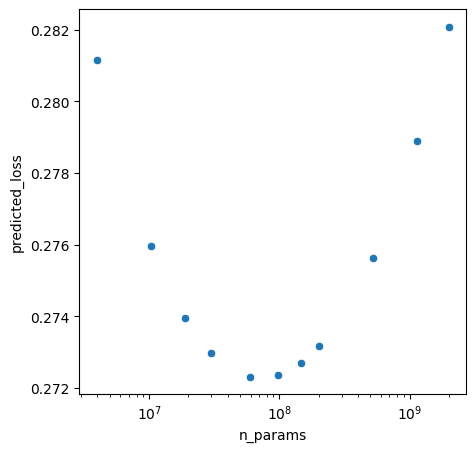

In [66]:
plt.figure(figsize=(5, 5))
sns.scatterplot(compute_optimal_df, x="n_params", y="predicted_loss")
plt.xscale("log")
# plt.ylim(0.275,0.285)

In [67]:
# 146M
compute_optimal_df = model_df.copy()
compute_optimal_df["n_flops"] = 5e21
compute_optimal_df["n_seq"] = compute_optimal_df["n_flops"] / compute_optimal_df["flops_per_seq"]
compute_optimal_df["n_seq"] = compute_optimal_df["n_seq"].round()
compute_optimal_df["n_tokens"] = compute_optimal_df["n_seq"] * 4096
compute_optimal_df["batch_size"] = ((gamma * c2) / (delta * c3)) ** (1 / (gamma + delta)) * (compute_optimal_df["n_seq"]) ** (delta / (gamma + delta))
compute_optimal_df["batch_size"] = compute_optimal_df["batch_size"].round()
compute_optimal_df["n_steps"] = compute_optimal_df["n_seq"] / compute_optimal_df["batch_size"]
compute_optimal_df["n_steps"] = compute_optimal_df["n_steps"].round()
compute_optimal_df["predicted_loss"] = scaling_law((compute_optimal_df["n_params"], compute_optimal_df["n_tokens"], compute_optimal_df["batch_size"], compute_optimal_df["n_steps"]), *params)
# find minimum loss
compute_optimal_df.loc[compute_optimal_df["predicted_loss"].idxmin()]

n_heads                                  8
d_head                                  64
d_model                                512
d_ffn                                 1280
n_blocks                                32
n_params                          97618944
name                                   98M
flops_per_seq                8535784899584
n_flops           5000000000000000000000.0
n_seq                          585769213.0
n_tokens                   2399310696448.0
batch_size                          6778.0
n_steps                            86422.0
predicted_loss                    0.269657
Name: 5, dtype: object

(0.269, 0.275)

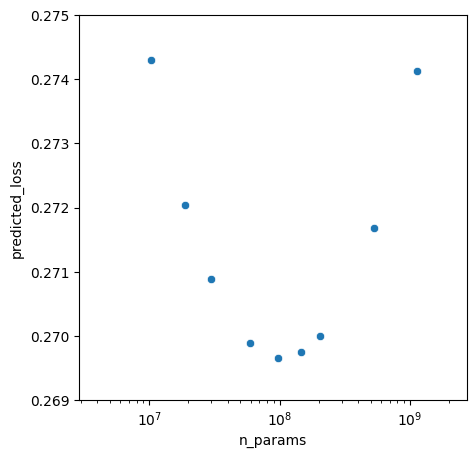

In [68]:
plt.figure(figsize=(5, 5))
sns.scatterplot(compute_optimal_df, x="n_params", y="predicted_loss")
plt.xscale("log")
plt.ylim(0.269,0.275)

In [ ]:
# These models were trained on 8xH100 GPUs ml-foundry instances
df = pd.DataFrame()
df["n_heads"] = [2, 3, 4, 6, 8, 10]
df["d_head"] = 64
df["d_model"] = df["n_heads"] * df["d_head"]
df["d_ffn"] = (df["d_model"] * 2.5).astype(int)
df["n_blocks"] = 32
df["n_params"] = get_n_params(
    GENE_VOCAB_SIZE,
    METADATA_VOCAB_SIZE,
    GENE_VALUE_VOCAB_SIZE,
    df["d_model"],
    df["d_ffn"],
    df["n_blocks"],
    SEQ_LEN,
)
df["name"] = ["10M", "19M", "30M", "59M", "98M", "146M"]
df["flops_per_seq"] = get_flops_per_seq(
    GENE_VALUE_VOCAB_SIZE,
    METADATA_VOCAB_SIZE,
    GENE_VALUE_VOCAB_SIZE,
    df["d_model"],
    df["d_ffn"],
    df["n_blocks"],
    df["d_head"],
    SEQ_LEN,
)
df["n_flops"] = [8e19, 1.6e20, 4.2e20, 1e21, 2.5e21, 5e21]
df["n_seq"] = df["n_flops"] / df["flops_per_seq"]
df["n_seq"] = df["n_seq"].round()
df["n_tokens"] = df["n_seq"] * 4096
df["tpp"] = df["n_tokens"] / df["n_params"]
df["batch_size"] = ((gamma * c2) / (delta * c3)) ** (1 / (gamma + delta)) * (df["n_seq"]) ** (delta / (gamma + delta))
df["batch_size"] = (df["batch_size"] / 8 / 64).round() * 8 * 64
df["n_steps"] = df["n_seq"] / df["batch_size"]
df["n_steps"] = df["n_steps"].round()
df["predicted_loss"] = scaling_law((df["n_params"], df["n_tokens"], df["batch_size"], df["n_steps"]), *params)
df.loc[0, "loss"] = 0.276400119066238
df.loc[0, "cell_type"] = 0.9217142462730408
df.loc[0, "development_stage"] = 1.0671143531799316
df.loc[0, "disease"] = 0.20557211339473724
df.loc[0, "gene_value"] = 0.16643181443214417
df.loc[0, "sex"] = 0.21758148074150085
df.loc[0, "tissue"] = 0.5530623197555542
df.loc[1, "loss"] = 0.272636353969574
df.loc[1, "cell_type"] = 0.9019674062728882
df.loc[1, "development_stage"] = 1.045974612236023
df.loc[1, "disease"] = 0.20041829347610474
df.loc[1, "gene_value"] = 0.16561803221702576
df.loc[1, "sex"] = 0.21179036796092987
df.loc[1, "tissue"] = 0.5396251678466797
df.loc[2, "loss"] = 0.2674964964389801
df.loc[2, "cell_type"] = 0.8755924105644226
df.loc[2, "development_stage"] = 1.0194114446640015
df.loc[2, "disease"] = 0.19379182159900665
df.loc[2, "gene_value"] = 0.16422824561595917
df.loc[2, "sex"] = 0.20713689923286438
df.loc[2, "tissue"] = 0.5218465328216553
df.loc[3, "loss"] = 0.264131635427475
df.loc[3, "cell_type"] = 0.8591803908348083
df.loc[3, "development_stage"] = 0.999607503414154
df.loc[3, "disease"] = 0.19028466939926147
df.loc[3, "gene_value"] = 0.16326184570789337
df.loc[3, "sex"] = 0.20454467833042145
df.loc[3, "tissue"] = 0.509728193283081
df.loc[4, "loss"] = 0.26091086864471436
df.loc[4, "cell_type"] = 0.8429098725318909
df.loc[4, "development_stage"] = 0.9803693890571594
df.loc[4, "disease"] = 0.18551035225391388
df.loc[4, "gene_value"] = 0.16246207058429718
df.loc[4, "sex"] = 0.20121704041957855
df.loc[4, "tissue"] = 0.4989112317562103
df["batch_size"] = df["batch_size"].astype(int)
model_df = df
model_df

,n_heads,d_head,d_model,d_ffn,n_blocks,n_params,name,flops_per_seq,n_flops,n_seq,...,batch_size,n_steps,predicted_loss,loss,cell_type,development_stage,disease,gene_value,sex,tissue
0,2,64,128,320,32,10248960,10M,1786053873920,8.000000e+19,44791482.0,...,2048,21871.0,0.292463,0.276400,0.921714,1.067114,0.205572,0.166432,0.217581,0.553062
1,3,64,192,480,32,18912384,19M,2766053898624,1.600000e+20,57844137.0,...,2048,28244.0,0.287242,0.272636,0.901967,1.045975,0.200418,0.165618,0.211790,0.539625
2,4,64,256,640,32,29935104,30M,3804035981824,4.200000e+20,110409050.0,...,3072,35940.0,0.281032,0.267496,0.875592,1.019411,0.193792,0.164228,0.207137,0.521847
3,6,64,384,960,32,59058432,59M,6053946323712,1.000000e+21,165181511.0,...,3584,46089.0,0.276449,0.264132,0.859180,0.999608,0.190285,0.163262,0.204545,0.509728
4,8,64,512,1280,32,97618944,98M,8535784899584,2.500000e+21,292884606.0,...,4608,63560.0,0.272355,0.260911,0.842910,0.980369,0.185510,0.162462,0.201217,0.498911
5,10,64,640,1600,32,145616640,146M,11249551709440,5.000000e+21,444462155.0,...,5632,78917.0,0.269747,NaN,NaN,NaN,NaN,NaN,NaN,NaN


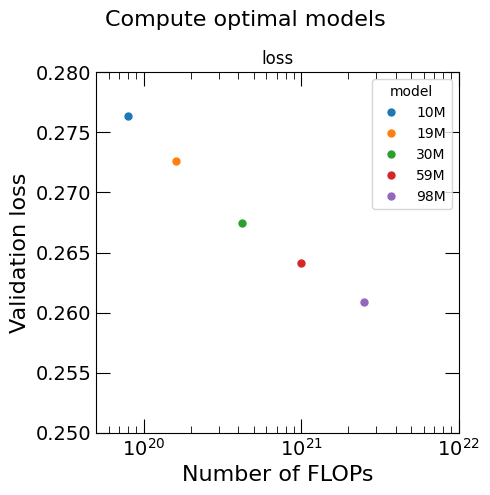

In [70]:
plt.figure(figsize=(5, 5))
label = "loss"
for i in range(5):
    plt.plot(df.loc[i, "n_flops"], df.loc[i, label], "o", ms=5, label=df.loc[i, "name"])
ax = plt.gca()
plt.xscale("log")
plt.legend(title="model")
plt.title(label)
plt.ylabel("Validation loss", fontsize=16)
plt.xlabel("Number of FLOPs", fontsize=16)
plt.tick_params(labelsize=14)
plt.tick_params(direction="in", which="major", length=10, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction="in", which="minor", length=5, bottom=True, top=True, left=True, right=True)
plt.ylim(0.25, 0.28)
plt.xlim(5e19, 1e22)
plt.suptitle("Compute optimal models", fontsize=16)
plt.tight_layout()

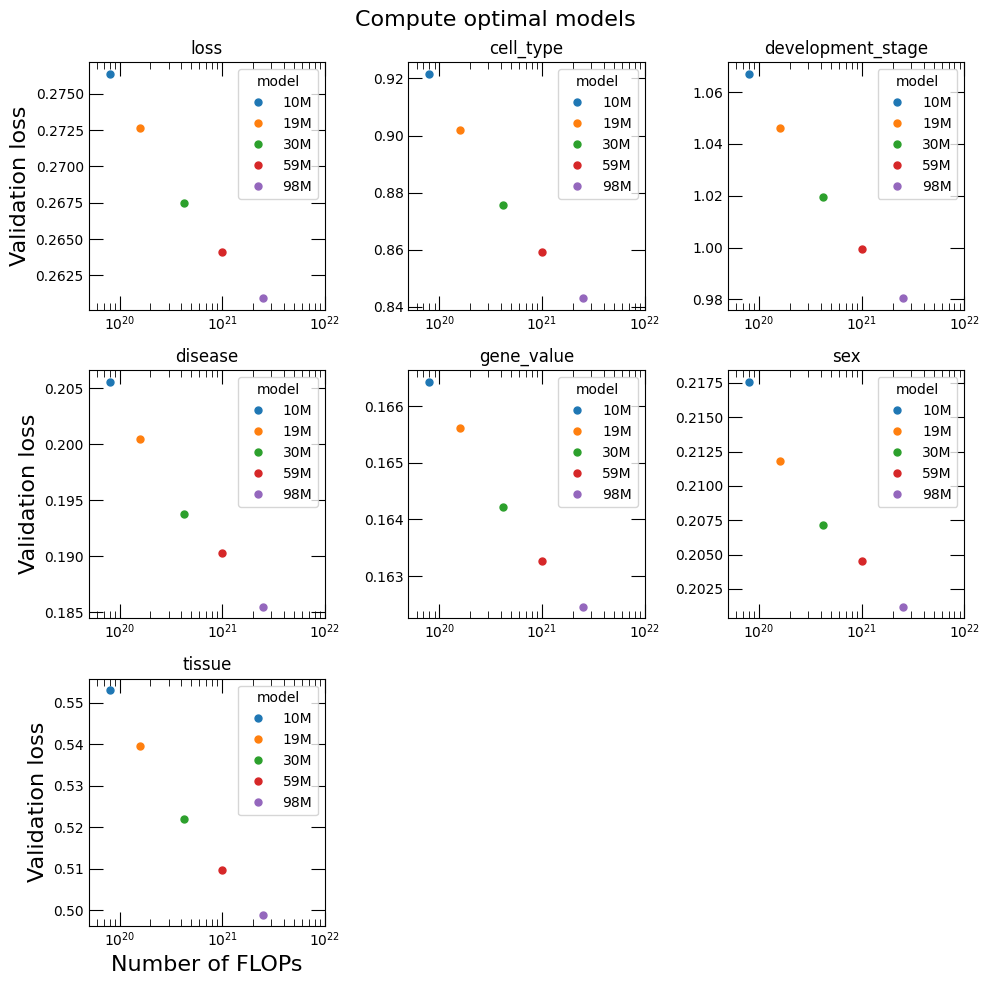

In [71]:
plt.figure(figsize=(10, 10))
for j, label in enumerate(["loss", "cell_type", "development_stage", "disease", "gene_value", "sex", "tissue"]):
    plt.subplot(3, 3, j+1)
    for i in range(5):
        plt.plot(df.loc[i, "n_flops"], df.loc[i, label], "o", ms=5, label=df.loc[i, "name"])
    ax = plt.gca()
    plt.xscale("log")
    plt.legend(title="model")
    plt.title(label)
    if j % 3 == 0:
        plt.ylabel("Validation loss", fontsize=16)
    if j // 3 == 2:
        plt.xlabel("Number of FLOPs", fontsize=16)
    # plt.tick_params(labelsize=14)
    plt.tick_params(direction="in", which="major", length=10, bottom=True, top=True, left=True, right=True)
    plt.tick_params(direction="in", which="minor", length=5, bottom=True, top=True, left=True, right=True)
    # plt.ylim(0.25, 0.28)
    plt.xlim(5e19, 1e22)
plt.suptitle("Compute optimal models", fontsize=16)
plt.tight_layout()